In [373]:
import os
import json
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")


In [374]:
data_dir_path = r"C:\Users\ethan_haque\Downloads\books"

In [375]:
# get paths to all json files recursively
json_files = []
for root, dirs, files in os.walk(data_dir_path):
    for file in files:
        if file.endswith(".json"):
             json_files.append(os.path.join(root, file))



In [376]:
print(len(json_files))
for file in json_files[:5]:
    print(file)

68
C:\Users\ethan_haque\Downloads\books\Emily\Batch 1 training set\Emily user 1433-2281 (8).json
C:\Users\ethan_haque\Downloads\books\Emily\Batch 10\Emily user 9-2962.json
C:\Users\ethan_haque\Downloads\books\Emily\Batch 23\Emily user 50-2995.json
C:\Users\ethan_haque\Downloads\books\Emily\Batch 24\Emily user 9-2962.json
C:\Users\ethan_haque\Downloads\books\Emily\Batch 25\Emily user 9-2962.json


In [377]:
def get_ra_and_batch_from_path(json_file_path):
    directory, filename = os.path.split(json_file_path)
    batch = directory.split("\\")[-1]
    ra = directory.split("\\")[-2]
    return ra, batch

In [378]:
# find directories without any directoreis in them that do not have json files
# these are errors
error_dirs = []
for root, dirs, files in os.walk(data_dir_path):
    if len(dirs) == 0:
        if len([file for file in files if file.endswith(".json")]) == 0:
            error_dirs.append(root)

In [379]:
error_dirs

[]

In [380]:
def convert_vgg_via_json_to_csv(json_file_path):
    data = read_json_data(json_file_path)
    ra, batch = get_ra_and_batch_from_path(json_file_path)
    rows = process_annotations(data, ra, batch)
    return rows

def read_json_data(json_file_path):
    with open(json_file_path, "r") as f:
        data = json.load(f)
    return list(data["_via_img_metadata"].items())

def get_row_data_from_annotation(image_id, annotation, identifiable_catories, diversity_categories):
    row = {
        "image_id": image_id,
        "filename": annotation.get("filename", ""),
        "title": annotation.get("file_attributes", {}).get("title", ""),
        "google": annotation.get("file_attributes", {}).get("google", ""),
        "errors": []
    }

    identifiable = annotation.get("file_attributes", {}).get("identifiable", "")
    for category, value in identifiable_catories.items():
        row[value] = category == identifiable

    diversity = annotation.get("file_attributes", {}).get("diversity", {})
    for category, value in diversity_categories.items():
        row[value] = diversity.get(category, False)

    if not identifiable:
        row["errors"].append("Exactly one identifiable selection required.")
    if not diversity and identifiable and identifiable != "no":
        row["errors"].append("At least one diversity selection required.")
    if row["title"] and not row["google"]:
        row["errors"].append("Google link required if title is present.")
    if row["google"] and not row["title"]:
        row["errors"].append("Title required if Google link is present.")

    row["errors"] = "; ".join(row["errors"])

    return row

def process_annotations(data, ra, batch):
    identifiable_catories = {
        "yes": "identifiable_yes",
        "no": "identifiable_no",
        "with info sidebar": "identifiable_with_info_sidebar",
        "with detective work": "identifiable_with_detective_work"
    }

    diversity_categories = {
        "none": "diversity_none",
        "bipoc": "diversity_bipoc",
        "woman": "diversity_woman",
        "lgbt": "diversity_lgbt",
        "non-christian": "diversity_non_christian",
        "disability": "diversity_disability",
        "other": "diversity_other",
        "ambiguous": "diversity_ambiguous"
    }

    rows = [get_row_data_from_annotation(image_id, annotation, identifiable_catories, diversity_categories) for image_id, annotation in data]
    for row in rows:
        row["ra"] = ra
        row["batch"] = batch
        
    return rows


In [381]:
all_rows = []
for file in json_files:
    all_rows.extend(convert_vgg_via_json_to_csv(file))

In [382]:
# turn into dataframe and write to csv
output_dir = "../books_report"
output_path = os.path.join(output_dir, "annotations.csv")
df = pd.DataFrame(all_rows)
df.to_csv(output_path, index=False)

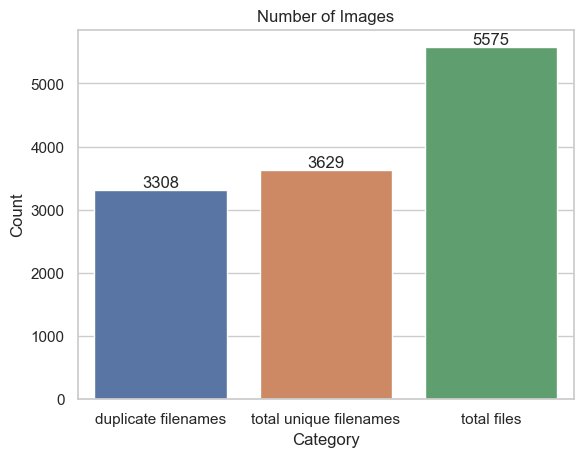

In [ ]:
no_duplicates = df.drop_duplicates(subset=["filename"])

df["duplicate"] = df.duplicated(subset=["filename"], keep=False)
df["unique"] = ~df["duplicate"]
df["duplicate"] = df["duplicate"].astype(int)
df["unique"] = df["unique"].astype(int)


data = {
    "duplicate filenames": df["duplicate"].sum(),
    "total unique filenames": no_duplicates.shape[0],
    "total files": df["unique"].sum() + df["duplicate"].sum(),
}

ax = sns.barplot(x=list(data.keys()), y=list(data.values()))
ax.set_title("Number of Images")
ax.set_ylabel("Count")
ax.set_xlabel("Category")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')

ax.figure.savefig(os.path.join(output_dir, "number_of_images.png"), bbox_inches="tight")

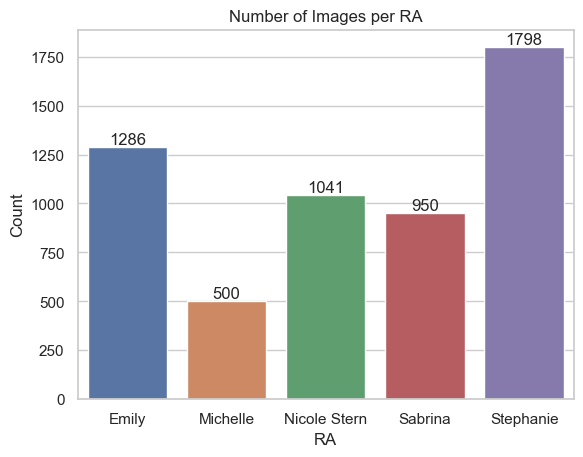

In [383]:
# create a bar plot of the number of image sper RA
data = df.groupby("ra").size().to_dict()
ax = sns.barplot(x=list(data.keys()), y=list(data.values()))
ax.set_title("Number of Images per RA")
ax.set_ylabel("Count")
ax.set_xlabel("RA")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')

ax.figure.savefig(os.path.join(output_dir, "number_of_images_per_ra.png"), bbox_inches="tight")

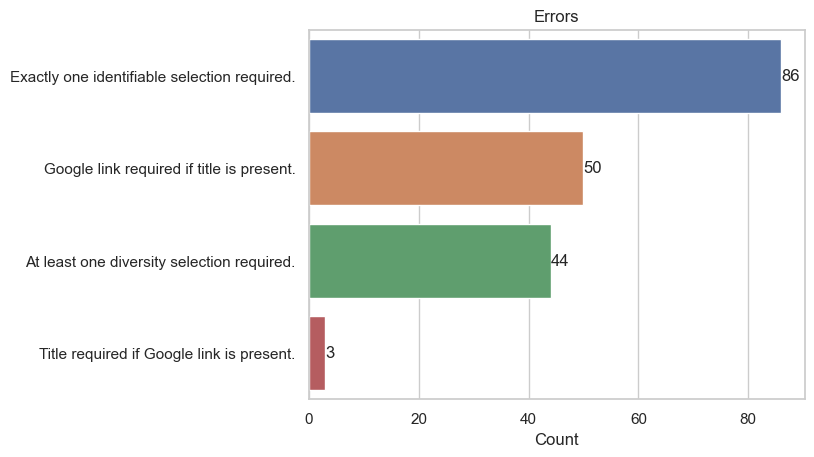

In [384]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined

data = df.groupby("errors").size().to_dict()
data_dictionary = {}
for key, value in data.items():
    if key:
        for error in key.split("; "):
            if error not in data_dictionary:
                data_dictionary[error] = 0
            data_dictionary[error] += value
data = data_dictionary
data = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}

ax = sns.barplot(x=list(data.values()), y=list(data.keys()))
ax.set_title("Errors")
ax.set_xlabel("Count")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
ax.figure.savefig(os.path.join(output_dir, "number_of_errors.png"), bbox_inches="tight")


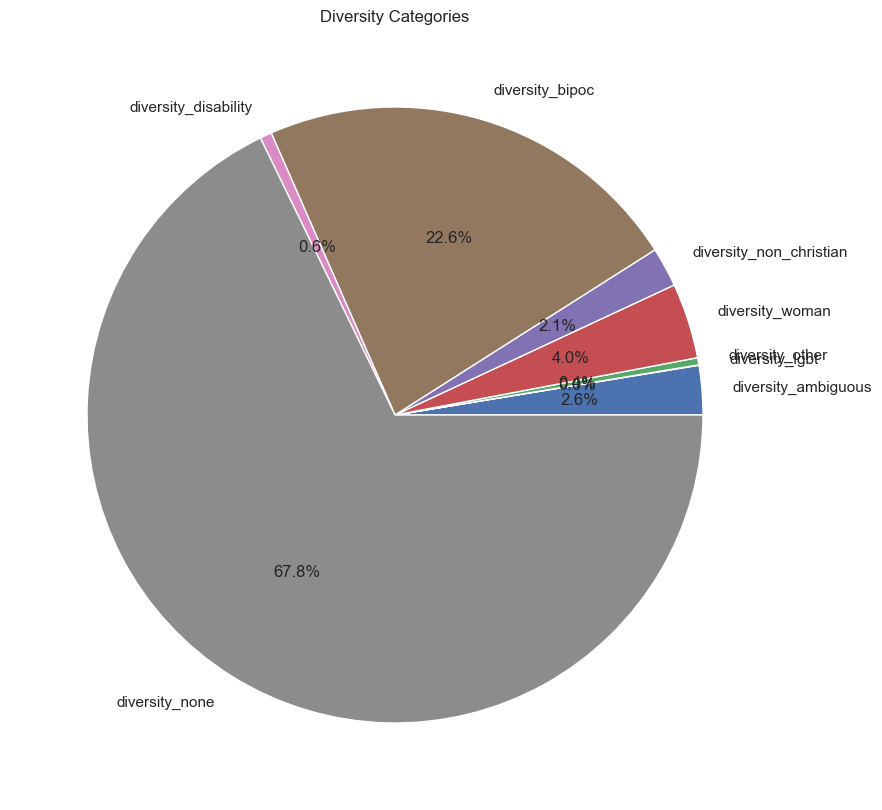

In [385]:
# create a pie chart of the different diversity categories
diversity_cols = [col for col in df.columns if col.startswith("diversity")]
data = df[diversity_cols].sum()
data = data.sample(frac=1)
ax = data.plot.pie(autopct="%.1f%%")
ax.set_title("Diversity Categories")
ax.set_ylabel("")
ax.figure.set_size_inches(10, 10)
ax.figure.savefig(os.path.join(output_dir, "diversity_categories.png"), bbox_inches="tight")

[Text(0, 0, '1022'),
 Text(0, 0, '179'),
 Text(0, 0, '1'),
 Text(0, 0, '94'),
 Text(0, 0, '28'),
 Text(0, 0, '17'),
 Text(0, 0, '117')]

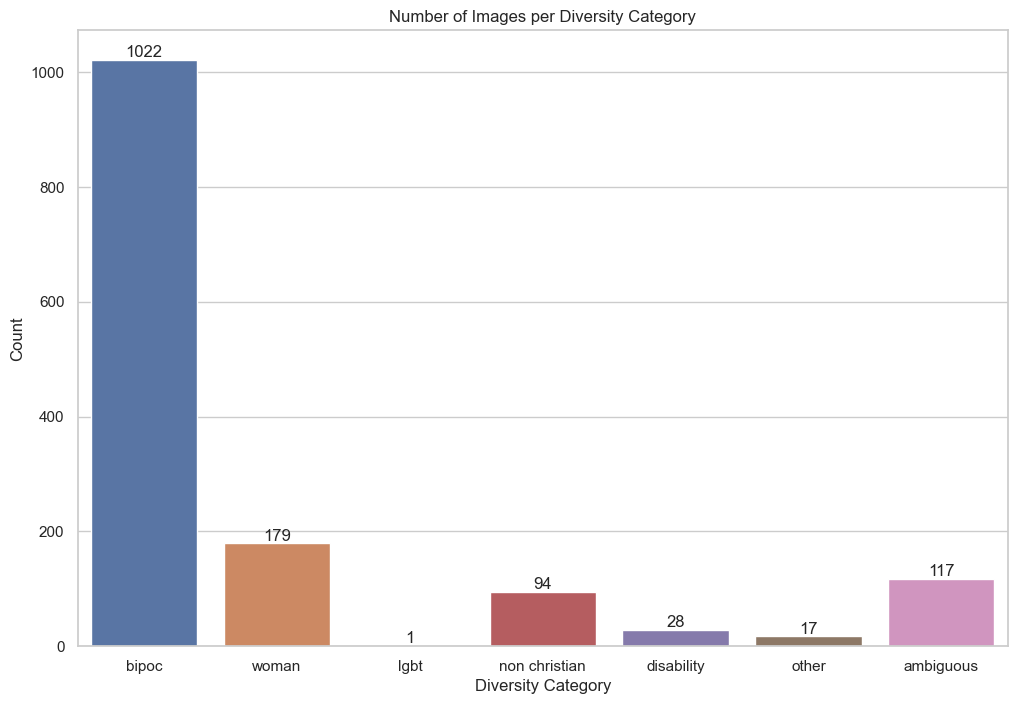

In [393]:
# show the number of images per diversity category
data = df[diversity_cols].sum().to_dict()
data = {key.replace("diversity_", "").replace("_", " "): value for key, value in data.items()}
ax = sns.barplot(x=list(data.keys()), y=list(data.values()))
ax.figure.set_size_inches(12, 8)
ax.set_title("Number of Images per Diversity Category")
ax.set_ylabel("Count")
ax.set_xlabel("Diversity Category")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')


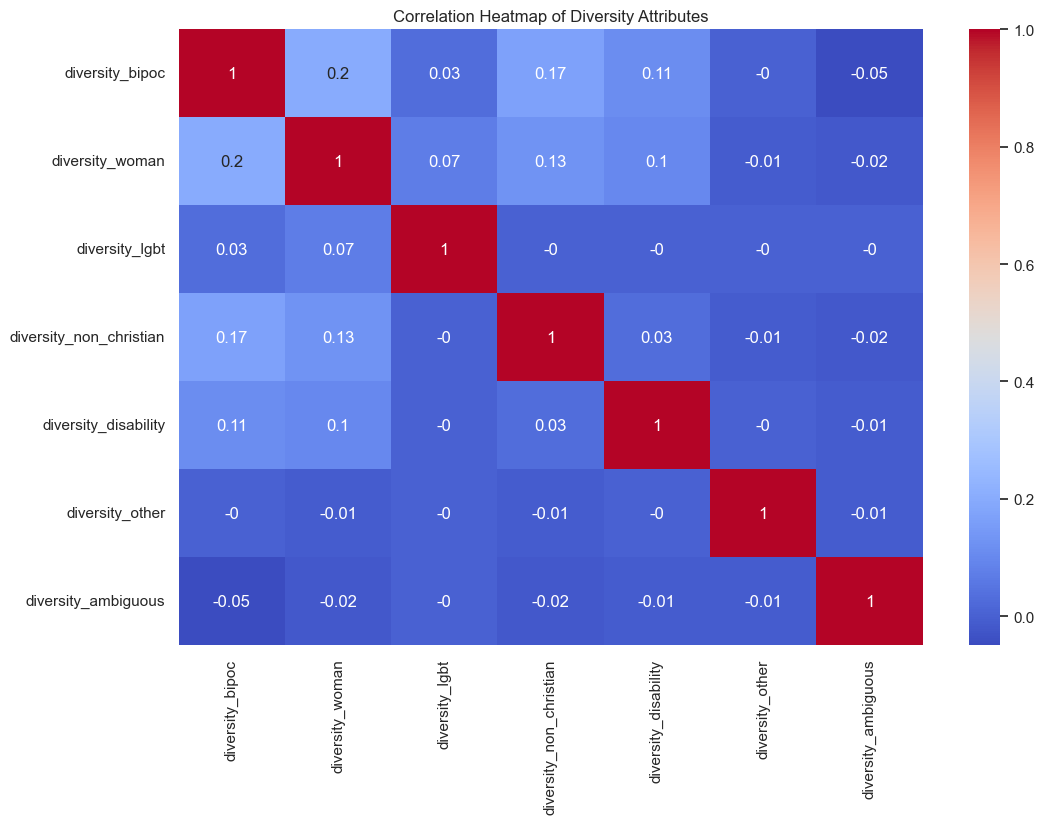

In [387]:
diversity_cols = [col for col in df.columns if col.startswith("diversity")]
diversity_cols.remove('diversity_none')
heatmap_data = df[diversity_cols]
ax = sns.heatmap(heatmap_data.corr().round(2), annot=True, cmap="coolwarm")
ax.set_title("Correlation Heatmap of Diversity Attributes")
ax.figure.set_size_inches(12, 8)
ax.figure.savefig(os.path.join(output_dir, "diversity_correlation_heatmap.png"), bbox_inches="tight")

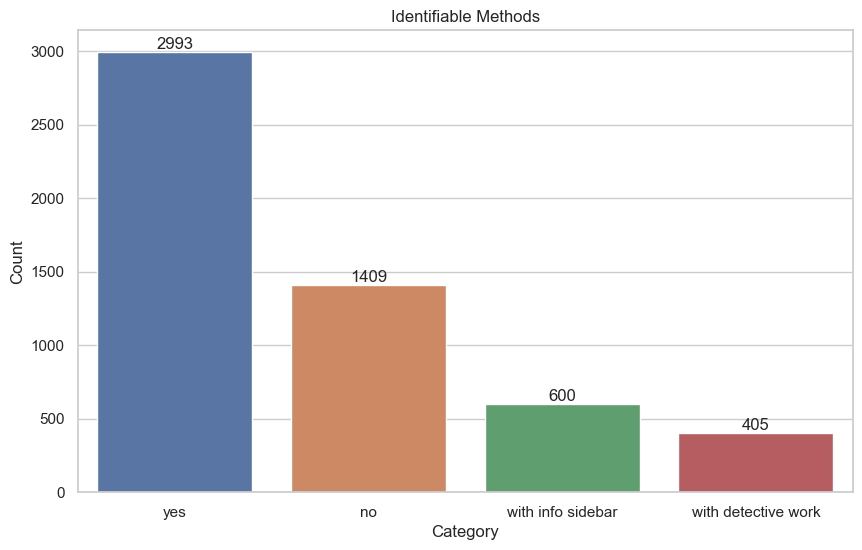

In [388]:
# create bar chart of the different identifiable methods
identifiable_cols = [col for col in df.columns if col.startswith("identifiable")]
data = df[identifiable_cols].sum().to_dict()
data = {key.replace("identifiable_", "").replace("_", " "): value for key, value in data.items()}
ax = sns.barplot(x=list(data.keys()), y=list(data.values()))
ax.figure.set_size_inches(10, 6)
ax.set_title("Identifiable Methods")
ax.set_ylabel("Count")
ax.set_xlabel("Category")
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
ax.figure.savefig(os.path.join(output_dir, "identifiable_methods.png"), bbox_inches="tight")